# Goal

- the goal from this notebook is to conduct Topic modeling for positive reviews for all the games using BerTopic

In [53]:
import pandas as pd
import pandas as pd
import os
import plotly.express as px
import plotly
import seaborn as sns
import numpy as np
import tqdm
import datetime
import re
import pandas as pd
import numpy as np
import spacy
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer


In [33]:
# reading game_reviews
games_reviews = pd.read_csv('games_reviews.csv')

In [34]:
games_reviews.dropna(subset=['clean_review'], inplace=True)
# calcuate the review length and word count
games_reviews['review_length'] = games_reviews['clean_review'].apply(len)
games_reviews['word_count'] = games_reviews['clean_review'].apply(lambda x: len(x.split()))
# # filter the reviews with word count less than 3
games_reviews = games_reviews[games_reviews['word_count'] >= 3]

games_reviews.shape

(1338281, 9)

In [35]:
games_reviews['length_group'] = games_reviews.review_length.map(
    lambda x: '<= 15' if x < 15 else '> 15'
)
games_reviews = games_reviews[games_reviews['length_group'] == '> 15']

In [36]:
# select the positive reviews
positive_reviews = games_reviews[games_reviews['sentiment'] == 'positive']
# select the negative reviews
negative_reviews = games_reviews[games_reviews['sentiment'] == 'negative']

In [37]:
negative_reviews.shape, positive_reviews.shape

((421344, 10), (760471, 10))

# Topic Modeling on Positive Reviews using BerTopic

In [38]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# min_cluster_size=10 lower cluster to reduce the outliers 

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings (I can also try with all-mpnet-base-v2 but takes more time)
  #umap_model=umap_model,                    # Step 2 - Reduce dimensionality (random_state=42 to reproduce the results)
  #hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings 
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics (can be tuned)
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words (can be tuned)
  #representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic represenations
  nr_topics="auto",
  calculate_probabilities=False, # accelerate the model training
  verbose=True, # show progress bars,
  #min_topic_size = 30, # higher to decrease the number of topics
)


In [39]:
pos_topics, pos_probs = topic_model.fit_transform(positive_reviews.review)

Batches: 100%|██████████| 23765/23765 [36:35<00:00, 10.83it/s]  
2023-11-26 10:47:39,461 - BERTopic - Transformed documents to Embeddings
2023-11-26 11:09:52,722 - BERTopic - Reduced dimensionality
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disab

In [40]:
topic_model.visualize_topics()

In [41]:
# saving negative topics and topic model as pickle
import pickle
with open('bert_models/pos_topics.pickle', 'wb') as f:
    pickle.dump(pos_topics, f)
with open('bert_models/pos_topic_model.pickle', 'wb') as f:
    pickle.dump(topic_model, f)

/Users/zoherorabe/Desktop/Excersices/wargaming/env/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [43]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10)
# some topics has non-meaningfull keywords

In [44]:
with open('bert_models/pos_topic_model.pickle', 'rb') as f:
    topic_model = pickle.load(f)


new_topics = topic_model.reduce_outliers(positive_reviews.review.values, pos_topics,strategy="c-tf-idf", threshold=0.001)
topic_model.update_topics(positive_reviews.review, topics=new_topics)

In [45]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10)
# some topics has non-meaningfull keywords

In [48]:
# update the topics with KeyBERTInspired

with open('bert_models/pos_topic_model.pickle', 'rb') as f:
    topic_model = pickle.load(f)
    
representation_model = KeyBERTInspired()
topic_model.update_topics(positive_reviews.review,representation_model= representation_model)


In [50]:
new_topics = topic_model.reduce_outliers(positive_reviews.review.values, pos_topics,strategy="c-tf-idf", threshold=0.001)
topic_model.update_topics(positive_reviews.review, topics=new_topics)

In [51]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10)
# some topics has non-meaningfull keywords

In [115]:
with open('bert_models/pos_topic_model.pickle', 'rb') as f:
    topic_model = pickle.load(f)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
stopwords = nlp.Defaults.stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bertopic.representation import MaximalMarginalRelevance


In [116]:
representation_model = MaximalMarginalRelevance(diversity=0.7)
vectorizer_model = CountVectorizer(stop_words=list(stopwords), ngram_range=(1, 1),token_pattern=r'\b\w{5,}\b')
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model.update_topics(positive_reviews.review, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model,representation_model= representation_model)

In [117]:
topic_model.visualize_barchart(top_n_topics = 10, n_words = 10)
# some topics has non-meaningfull keywords

In [118]:
new_topics = topic_model.reduce_outliers(positive_reviews.review.values, pos_topics,strategy="c-tf-idf", threshold=0.01)
topic_model.update_topics(positive_reviews.review, topics=new_topics)

In [119]:
topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)
# some topics has non-meaningfull keywords

In [120]:
topic_model.merge_topics(positive_reviews.review, [[325, 281,287],[257,313,240,70,154,26,0]])

In [121]:
topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)
# some topics has non-meaningfull keywords

In [128]:
topic_model.merge_topics(positive_reviews.review, [[0,3,5,9,10,8]])

In [129]:
topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)
# some topics has non-meaningfull keywords

In [134]:
topic_model.merge_topics(positive_reviews.review, [[3,8],[0,1,12]])

In [135]:
topic_model.visualize_barchart(top_n_topics = 15, n_words = 10)
# some topics has non-meaningfull keywords

In [136]:
# Topic 1: Pleasent 
topic_model.get_topic_info(0).values

array([[0, 469833, '0_game_this_love_is',
        list(['game', 'this', 'love', 'is', 'it', 'best', 'the', 'fun', 'but', 'very']),
        list(["Very Nice Update Of 1.6.0 Thank You Pubg Mobile This Is Very Very Nice Update and I'm Playing Pubg From Season 5", 'Very good game this we will enjoy and there are very time to we play free fire', 'The best game for me and I like it so much'])]],
      dtype=object)

In [138]:
# Topic 2: Updates
topic_model.get_topic_info(1).values

array([[1, 5657, '1_update_options_updates_upgrade',
        list(['update', 'options', 'updates', 'upgrade', 'laggy', 'going', 'option', 'everybody', 'normal', 'state']),
        list(['I like this game but it is update', 'It,s good game but the new update is not Good', "new update l can't in the game in update 1.5.0"])]],
      dtype=object)

In [139]:
# Topic 3: Devices
topic_model.get_topic_info(2).values

array([[2, 4026, '2_android_mobile_devices_phones',
        list(['android', 'mobile', 'devices', 'phones', 'pubg', 'redmi', 'tablet', 'low', '5star', 'specially']),
        list(['Please can play this game on Android 9', 'The best game for Android. I love it. But ONLY in Mobile phones top.', 'Nice games for Android mobile'])]],
      dtype=object)

In [140]:
# Topic 4: Game Level
topic_model.get_topic_info(3).values

array([[3, 2908, '3_harder_starts_sharp_pretty',
        list(['harder', 'starts', 'sharp', 'pretty', 'challenging', 'slowly', 'progress', 'extremely', 'begin', 'patient']),
        list(["Just downloaded. So far so good. I'm at level 10, been really easy. Sure it'll get harder, and if it starts asking for money, I'll definitely let you know.", 'Easy at first but getting harder now', 'Fun Game. Harder as you go.'])]],
      dtype=object)

In [141]:
# Topic 5: download
topic_model.get_topic_info(4).values

array([[4, 2699, '4_download_running_downloading_obb',
        list(['download', 'running', 'downloading', 'obb', 'resources', 'install', 'uninstall', 'service', 'error', 'again']),
        list(['This game is very good 👍👌👏download and play the game', 'IT IS A VERY GOOD GAME PLEASE DOWNLOAD AND PLAY IT', 'When i enter the pubg app, its showing DOWNLOAD OBB SERVICE IS RUNNING, can you help me on this??'])]],
      dtype=object)

In [142]:
# Topic 6: Graphics
topic_model.get_topic_info(5).values

array([[5, 2371, '5_graphics_position_nc_gamee',
        list(['graphics', 'position', 'nc', 'gamee', 'thish', 'ilike', '4star', 'injoy', 'graphic', 'thrill']),
        list(['Love the Game,very good graphics.', 'good game and graphics', 'Game graphics is good'])]],
      dtype=object)

In [146]:
# Topic 7: Airdrop 
topic_model.get_topic_info(9).values

array([[9, 2158, '9_airdrop_diamond_rupees_air',
        list(['airdrop', 'diamond', 'rupees', 'air', 'drop', '30', 'passing', 'diomand', 'top', 'airdrops']),
        list(['I have a request for you garena sir please give special airdrop of user 95 rupees only because most of players do only airdrop like me from 2 to 3 months I am not getting good airdrop', 'I need 30 rupees airdrop send me please garena', 'Please change my airdrop 30 rupees 300 diamond'])]],
      dtype=object)

In [148]:
# Topic 9: Price 
topic_model.get_topic_info(10).values

array([[10, 2055, '10_lower_price_prices_expensive',
        list(['lower', 'price', 'prices', 'expensive', 'decrease', 'peace', 'needed', 'size', 'high', 'gb']),
        list(['Think you could lower the price for playing the game', 'I love this game but can you lower the price of top up', 'Please lower the price a little'])]],
      dtype=object)

In [150]:
Topic_Mapping = {0: 'Pleasent', 1: 'Updates', 2: 'Devices', 3: 'Game Level', 4: 'download', 5: 'Graphics', 9: 'Airdrop', 10: 'Price'}

Text(0.5, 0, 'Count')

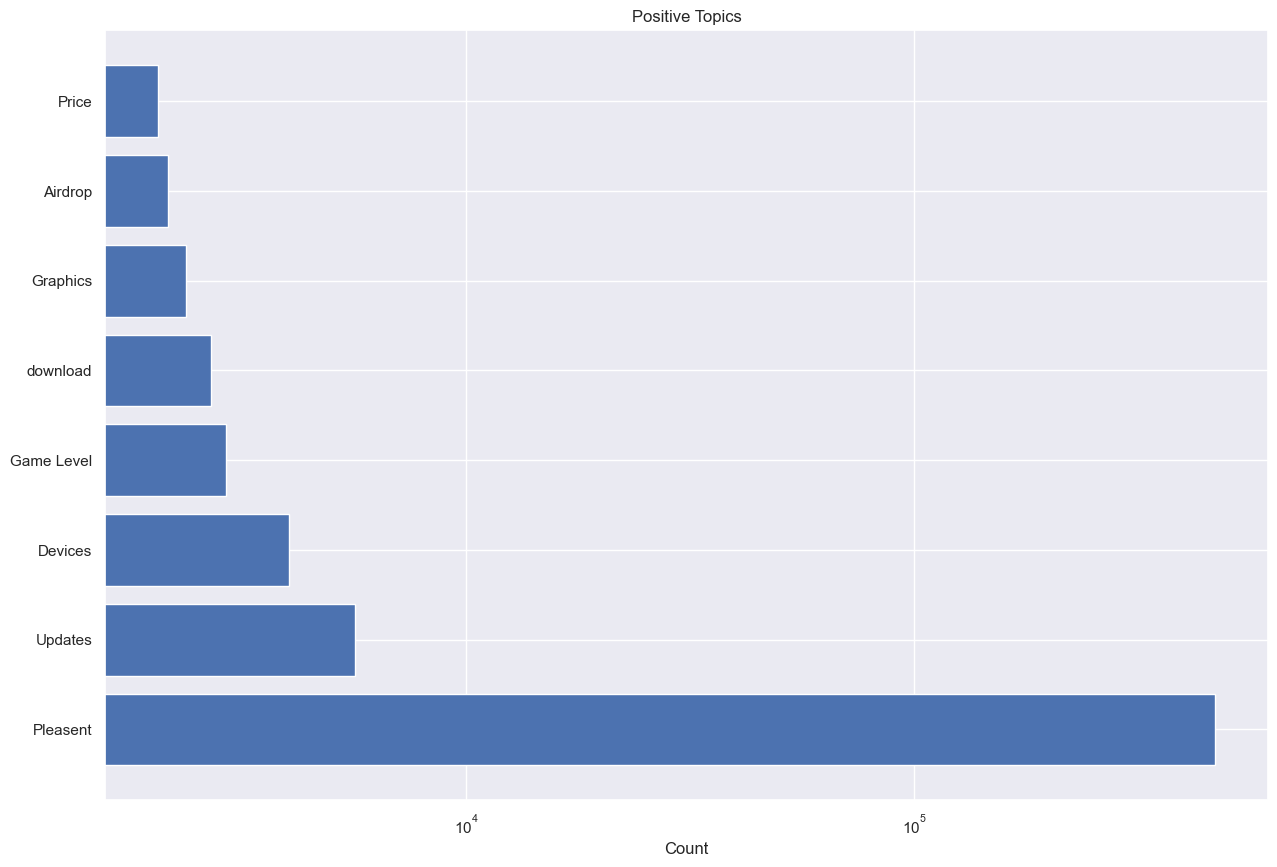

In [225]:
positive_topics = topic_model.get_topic_info()
# plot x, y
plt.figure(figsize=(15, 10))
plt.barh(list(Topic_Mapping.values()), positive_topics[positive_topics['Topic'].isin(Topic_Mapping.keys())]['Count'])
# log scale y-axis
plt.xscale('log')
plt.title('Positive Topics')
plt.xlabel('Count')


In [151]:
topics_per_class = topic_model.topics_per_class(positive_reviews.review, 
    classes=positive_reviews.app_name)
top_topics_per_class = topics_per_class[topics_per_class['Topic'].isin(Topic_Mapping.keys())].replace({"Topic": Topic_Mapping})


10it [00:06,  1.52it/s]


In [226]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_topic(topic, fig, row, col):
    trace = go.Bar(
        x=topic["Class"],
        y=topic["Frequency"],
        name="Topic: " + str(topic.Topic.iloc[0]),
        marker=dict(color=px.colors.qualitative.Prism)
    )
    fig.add_trace(trace, row=row, col=col)

# Create subplots
fig = sp.make_subplots(rows=len(Topic_Mapping)//2 + len(Topic_Mapping)%2, cols=2, subplot_titles=list(Topic_Mapping.values()))

# Populate subplots
for idx, i in enumerate(Topic_Mapping.values(), start=1):
    row = (idx - 1) // 2 + 1
    col = (idx - 1) % 2 + 1
    plot_topic(
        top_topics_per_class[top_topics_per_class['Topic'] == i].sort_values(by='Frequency', ascending=False),
        fig, row, col
    )

# Update layout
fig.update_layout(
    showlegend=True,
    title_text="Topics Distribution",
    title_x=0.5,
    height=1250,
    width=1100
)

# Update y-axis to log scale
fig.update_yaxes(type="log")

# Show the plot
fig.show()


In [153]:
for topic in top_topics_per_class.Topic.unique():
    print ('Topic: ',topic)
    print ('Class: ', top_topics_per_class[top_topics_per_class['Topic'] == topic].sort_values(by='Frequency', ascending=False)['Class'].iloc[0])
    print ('Frequency: ', top_topics_per_class[top_topics_per_class['Topic'] == topic].sort_values(by='Frequency', ascending=False)['Frequency'].iloc[0])
    print ('-'*50)

Topic:  Pleasent
Class:  Free Fire
Frequency:  127690
--------------------------------------------------
Topic:  Updates
Class:  PUBG MOBILE
Frequency:  1944
--------------------------------------------------
Topic:  Devices
Class:  PUBG MOBILE
Frequency:  2135
--------------------------------------------------
Topic:  Game Level
Class:  Wordscapes
Frequency:  646
--------------------------------------------------
Topic:  download
Class:  Call of Duty: Mobile
Frequency:  983
--------------------------------------------------
Topic:  Graphics
Class:  Call of Duty: Mobile
Frequency:  899
--------------------------------------------------
Topic:  Airdrop
Class:  Free Fire
Frequency:  1731
--------------------------------------------------
Topic:  Price
Class:  Call of Duty: Mobile
Frequency:  629
--------------------------------------------------


In [155]:
documents_with_topic = topic_model.get_document_info(positive_reviews.review)

In [157]:
documents_with_topic['date'] = positive_reviews['dt'].to_list()

In [158]:
topics_over_time = topic_model.topics_over_time(documents_with_topic['Document'].to_list(),  documents_with_topic['date'].to_list(), nr_bins=10)

10it [00:57,  5.73s/it]


In [209]:
topics = Topic_Mapping.values()

In [212]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
